### Chapter 2 – End-to-end Machine Learning project

Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.

# Project Checklist

1. [x] Frame the problem and look at the big picture.
2. [x] Get the data.
3. [x] Explore the data to gain insights.
4. [x] Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.
5. [x] Explore many different models and short-list the best ones.
6. [x] Fine-tune your models and combine them into a great solution.

# Libraries

In [63]:
import os
import tarfile
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import joblib
from pandas.plotting import scatter_matrix
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Data

## Download

In [2]:
# Get tar file (compacted csv)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
# Download and extract data
fetch_housing_data()

In [4]:
# Function to load data to a Pandas DataFrame
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
# df is our DataFrame
df = load_housing_data()

## Data structure

In [6]:
# Seeing 5 first lines
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
# Number of rows, columns, non-null values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
# Getting all the categorical variables of ocean_proximity
df["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [9]:
# Descriptive statistics
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


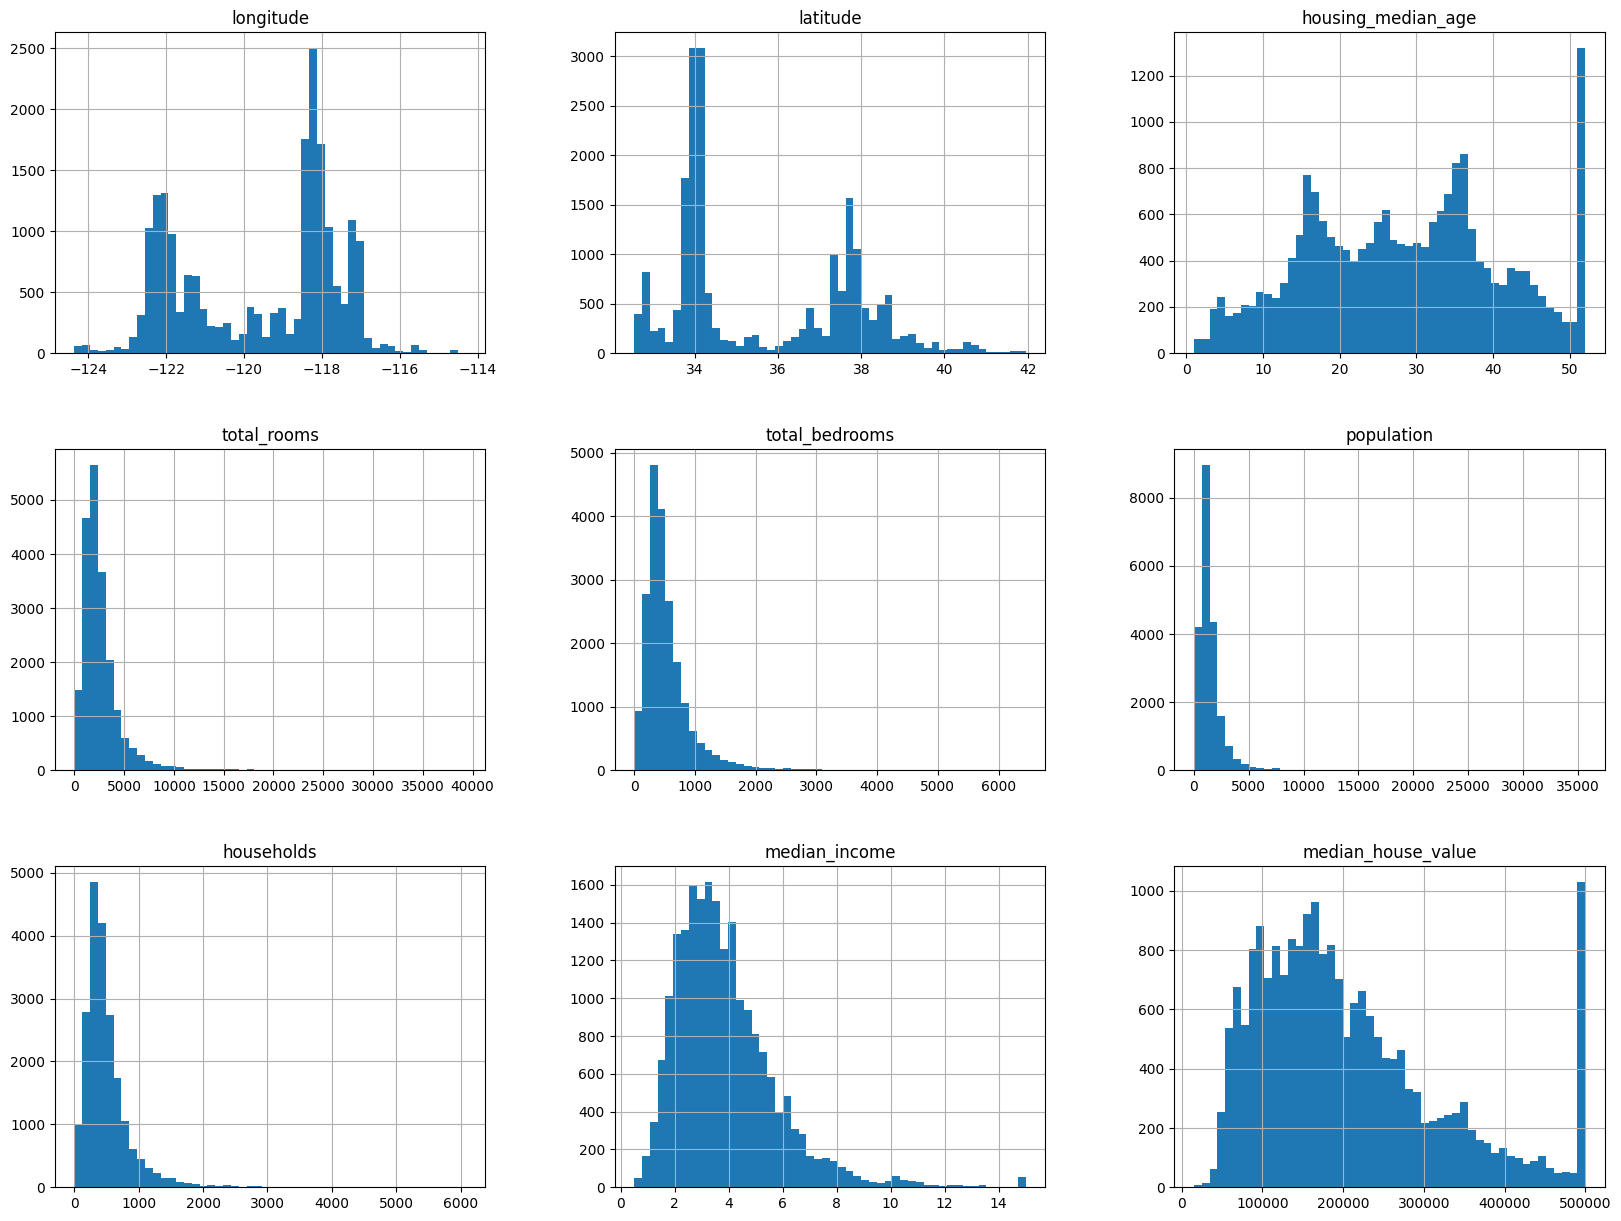

In [10]:
# Histograms of numerical variables
df.hist(figsize=(20, 15), bins=50)
plt.show()

## Split data into train and test

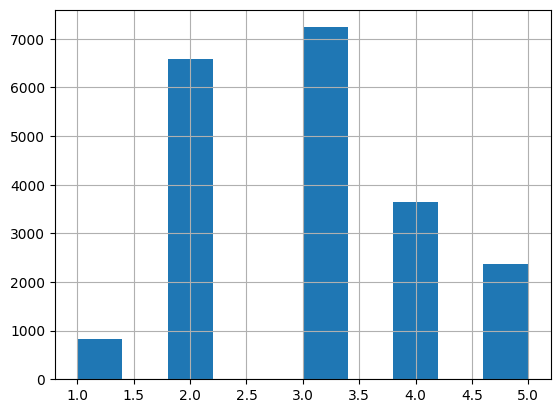

In [11]:
# Creating income categories for stratified sampling
df["income_cat"] = pd.cut(df["median_income"],
                          bins=[0, 1.5, 3, 4.5, 6, np.inf],
                          labels=[1, 2, 3, 4, 5])
df["income_cat"].hist()
plt.show()

In [12]:
# Stratified shuffle spliting
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [13]:
df_train = strat_train_set
df_test = strat_test_set

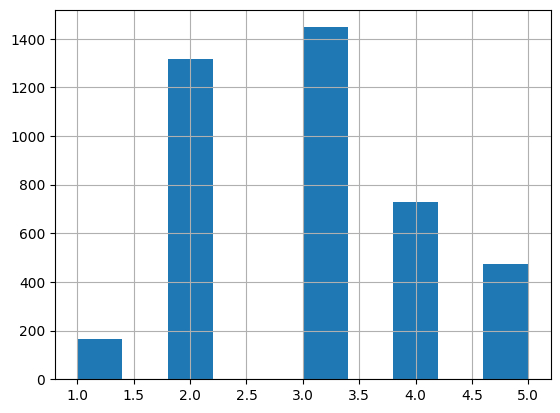

In [14]:
# Now the train and test samples look representative of the original data
df_test["income_cat"].hist()
plt.show()

In [15]:
# Removing the income_cat column from our train and test data
df_train = df_train.drop(columns="income_cat")
df_test = df_test.drop(columns="income_cat")

Remember that from now on we will only analyze df_train set, but all changes applied to our train data must also be applied do df_test

# Exploratory analysis

## Visualizations

In [16]:
# Working with copy of df_train
housing = df_train.copy()

In [17]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000


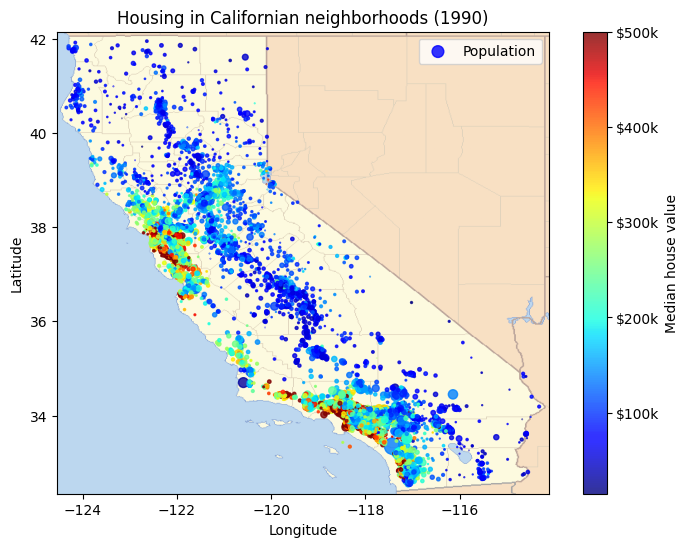

In [18]:
fig, ax = plt.subplots()
height, width = 6, 9
fig.set_figheight(height)
fig.set_figwidth(width)
ax.set_aspect("auto")
# Loading background image
img = mpimg.imread("img/california.png")
# Showing image
coordinates = [housing["longitude"].min() - 0.2, housing["longitude"].max() + 0.2,
               housing["latitude"].min() - 0.2, housing["latitude"].max() + 0.2]
image = ax.imshow(img, extent=coordinates, alpha=0.7)
# Scatterplot
scatter = ax.scatter(x=housing["longitude"], y=housing["latitude"],
                     s=housing["population"]/250, marker="o", alpha=0.8,
                     label="Population", c=housing["median_house_value"],
                     cmap="jet")
# Labels
ax.set(title="Housing in Californian neighborhoods (1990)",
       xlabel="Longitude", ylabel="Latitude")
# Legend
ax.legend()
# Colorbar
colorbar = fig.colorbar(scatter)
colorbar.set_label("Median house value")
tick_values = np.linspace(housing["median_house_value"].min() + 85000, 
                          housing["median_house_value"].max(), 5)
colorbar.ax.set_yticks(tick_values)
colorbar.ax.set_yticklabels([f"${round(v/1000)}k" for v in tick_values], fontsize=10)
# Display graph
plt.show()

## Correlation analysis

In [19]:
corr_matrix = housing.drop(columns="ocean_proximity").corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

There is a strong correlation between median_house_value and median_income

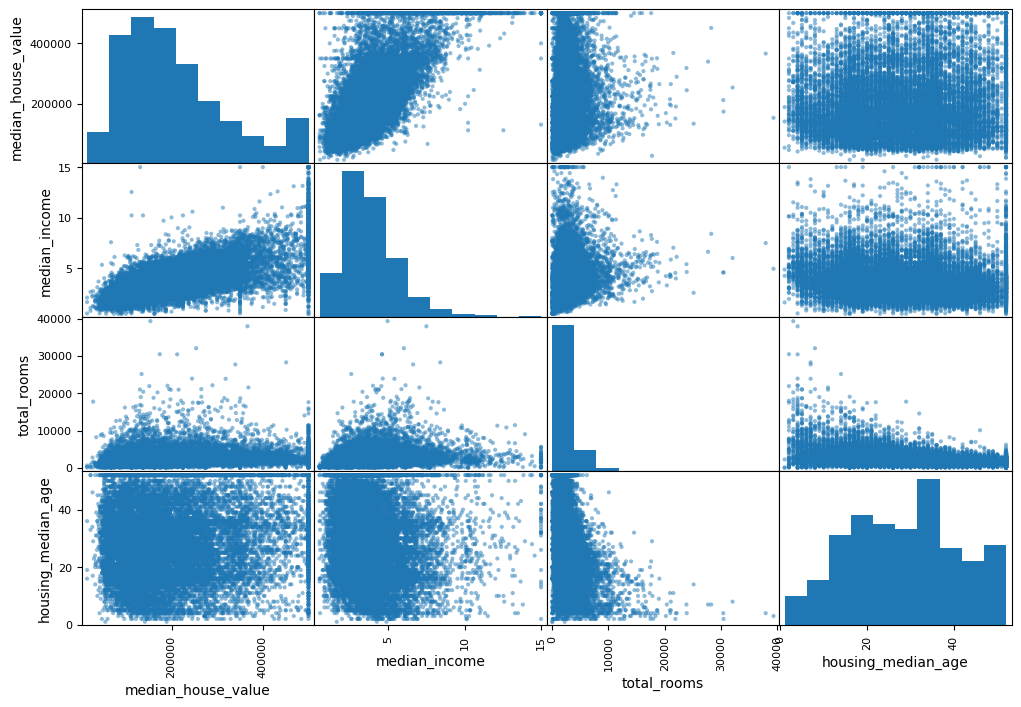

In [20]:
# Scatter matrix
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(frame=housing[attributes], figsize=(12, 8), diagonal="hist")
plt.show()

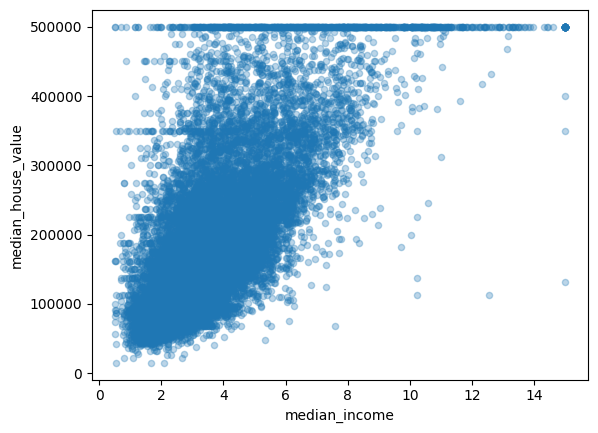

In [21]:
# median_income has the best correlation
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.3)
plt.show()

## Feature engineering

In [22]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


In [23]:
# Getting how many rooms there is per household
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
# Ratio of bedrooms and rooms
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
# People per household
housing["population_per_household"] = housing["population"] / housing["households"]

In [24]:
corr_matrix = housing.drop(columns="ocean_proximity").corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

The new feature bedrooms_per_room has an interesting negative correlation with median_house_value, as a low bedroom_per_room value indicates a house with way more rooms than bedrooms, thus, a big and more valuable one

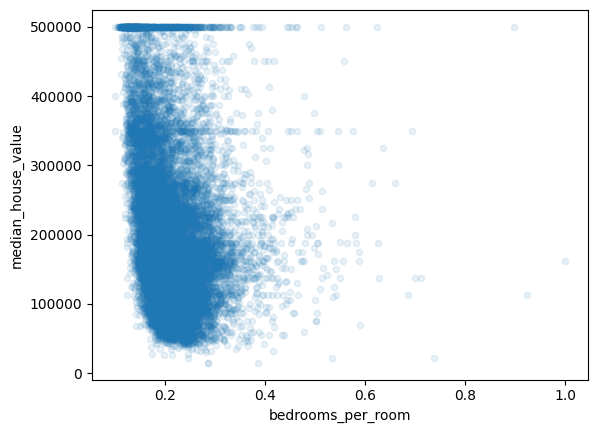

In [25]:
# bedrooms_per_room has interesting correlation
housing.plot(kind="scatter", x="bedrooms_per_room", y="median_house_value", alpha=0.1)
plt.show()

# Preparing data for ML modeling

In [26]:
# New copy of train dataset
housing = df_train.drop(columns="median_house_value").copy()
housing_labels = df_train["median_house_value"].copy()

## Data cleaning

In [27]:
# Dealing with missing values of total_bedrooms
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop(columns="ocean_proximity")  # Only numerical data
X = imputer.fit_transform(housing_num)  # Dataset as an array with replaced NaN values

In [28]:
# DataFrame without missing values
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.info()  # All values are now non-null

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


## Manipulating categorical features

In [29]:
housing_cat = np.array(housing["ocean_proximity"]).reshape(-1, 1)
housing_cat[:5]

array([['INLAND'],
       ['NEAR OCEAN'],
       ['INLAND'],
       ['NEAR OCEAN'],
       ['<1H OCEAN']], dtype=object)

In [30]:
# Encoding ocean_proximity (text -> number)
cat_encoder = OneHotEncoder()
housing_cat_encode = cat_encoder.fit_transform(housing_cat)
housing_cat_encode.toarray()[:5]

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

## Custom transformers

Transformer to add extra attributes

In [31]:
# Columns
cols = ['total_rooms', 'total_bedrooms', 'population', 'households']
# Columns index
rooms_ix, bedrooms_ix, population_ix, households_ix = [housing.columns.get_loc(i) for i in cols]

In [32]:
class BaseTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X=None, y=None):
        return self

In [99]:
class CombinedAttributesAdder(BaseTransformer):
    
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [34]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attr = attr_adder.transform(housing.values)
housing_extra_attr = pd.DataFrame(housing_extra_attr,
                                     columns=list(housing.columns) +
                                     ["rooms_per_household", "population_per_household"],
                                     index=housing.index)
housing_extra_attr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


## Pipelines

In [35]:
# Pipeline for numeric features
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),  # This is our custom transformer
    ("std_scaler", StandardScaler())])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [36]:
# Using ColumnTransform pipeline to deal with all data
num_attribs = list(housing_num)  # Numerical attributes columns names
cat_attribs = ["ocean_proximity"]  # Categorical attributes columns names

full_pipeline = ColumnTransformer([
    ("numerical", num_pipeline, num_attribs),
    ("categorical", OneHotEncoder(), cat_attribs)
])
# All columns have been transformed applying the fit and transformation through the full_pipeline
housing_prepared = full_pipeline.fit_transform(housing)

# Machine Learning Modeling

Exploring possible models

## Linear regression model

In [37]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [38]:
# Predictions x Labels
some_data = housing.head()
some_labels = housing_labels.head()
some_data_prepared = full_pipeline.transform(some_data)
print(f"Predictions: {lin_reg.predict(some_data_prepared)}")
print(f"Labels: {list(some_labels)}")

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [39]:
# Root means square error (RMSE)
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

The error is too high, the model is underfitting training data

## Decision tree regression model

In [40]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [41]:
# Predictions x Labels
some_data = housing.head()
some_labels = housing_labels.head()
some_data_prepared = full_pipeline.transform(some_data)
print(f"Predictions: {tree_reg.predict(some_data_prepared)}")
print(f"Labels: {list(some_labels)}")

Predictions: [ 72100. 279600.  82700. 112500. 238300.]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [42]:
# Root mean square error
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

This error is too low, the model is overfitting training data

## Random forest regression

In [43]:
rf_reg = RandomForestRegressor()
rf_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [44]:
# Predictions x Labels
some_data = housing.head()
some_labels = housing_labels.head()
some_data_prepared = full_pipeline.transform(some_data)
print(f"Predictions: {rf_reg.predict(some_data_prepared)}")
print(f"Labels: {list(some_labels)}")

Predictions: [ 75698.   292682.01  82008.   122669.   231783.  ]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [45]:
# Root mean square error
housing_predictions = rf_reg.predict(housing_prepared)
rf_mse = mean_squared_error(housing_labels, housing_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

18676.6431239417

This could be a good model

## Cross validation for trained models

In [46]:
def display_scores(scores):
    print(f"Scores: {scores}")
    print(f"Mean RMSE: {scores.mean()}")
    print(f"Standard deviation: {scores.std()}")

### Linear regression

In [47]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean RMSE: 69104.07998247063
Standard deviation: 2880.328209818065


### Decision tree regressor

In [48]:
tree_scores = cross_val_score(tree_reg, housing_prepared,
                         housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [73023.15211434 71573.52991535 68345.98849051 71092.13523981
 71167.1931146  77707.00987804 70380.67995039 74238.64607363
 68305.21975271 71748.38615922]
Mean RMSE: 71758.19406886215
Standard deviation: 2634.995403339921


The mean of the decision trees RMSE is worse than the RMSE of the linear model

### Random forest regressor

In [49]:
rf_scores = cross_val_score(rf_reg, housing_prepared, housing_labels,
                           scoring="neg_mean_squared_error", cv=10)
rf_rmse_scores = np.sqrt(-rf_scores)
display_scores(rf_rmse_scores)

Scores: [51262.34279161 48989.52763425 46716.69607158 51752.21590859
 47396.05899641 51783.98766457 52307.92821052 50113.48917894
 48557.9232708  53681.38098006]
Mean RMSE: 50256.15507073248
Standard deviation: 2162.023107391851


Clear winner! But still overperforming with the training data

## Saving tested models and results

In [50]:
folder = "trained-models"
if not os.path.exists(folder):
    os.mkdir(folder)
# Linear regression
joblib.dump(lin_reg, f"{folder}/lin_reg.pkl")
# Decision tree
joblib.dump(tree_reg, f"{folder}/tree_reg.pkl")
# Random forest
joblib.dump(rf_reg, f"{folder}/rf_reg.pkl")

['trained-models/rf_reg.pkl']

In [51]:
# Loading a trained model
rf_reg = joblib.load("trained-models/rf_reg.pkl")

# Model tuning

I chose the random forest and regressor and now I will find the best parameters for it

 ## Grid search

In [52]:
param_grid = [
    {"n_estimators": [3, 10, 30],
     "max_features": [2, 4, 6, 8]},
    {"bootstrap": [False],
     "n_estimators": [3, 10],
     "max_features": [2, 3, 4]}
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring="neg_mean_squared_error",
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [53]:
# Best parameters from grid search
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [54]:
# Evaluting scores
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

62819.55472363558 {'max_features': 2, 'n_estimators': 3}
55649.11741732402 {'max_features': 2, 'n_estimators': 10}
52803.107981990885 {'max_features': 2, 'n_estimators': 30}
60932.19482771728 {'max_features': 4, 'n_estimators': 3}
52763.722403355554 {'max_features': 4, 'n_estimators': 10}
50386.30698850187 {'max_features': 4, 'n_estimators': 30}
59052.021068593494 {'max_features': 6, 'n_estimators': 3}
51842.97518281945 {'max_features': 6, 'n_estimators': 10}
50028.978781998245 {'max_features': 6, 'n_estimators': 30}
59228.413122406244 {'max_features': 8, 'n_estimators': 3}
52144.13565787658 {'max_features': 8, 'n_estimators': 10}
49896.13472746661 {'max_features': 8, 'n_estimators': 30}
62900.104708501436 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54228.93442166488 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59898.84612355916 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52637.70088815121 {'bootstrap': False, 'max_features': 3, 'n_estimator

## Feature importance

In [55]:
feature_importance = grid_search.best_estimator_.feature_importances_
feature_importance

array([7.09889893e-02, 5.95052595e-02, 4.41530288e-02, 1.54689964e-02,
       1.51323305e-02, 1.63082078e-02, 1.38588365e-02, 3.99127340e-01,
       4.62936941e-02, 1.11867490e-01, 5.40572933e-02, 6.94492856e-03,
       1.40592884e-01, 1.37936202e-04, 2.26702076e-03, 3.29576303e-03])

In [56]:
extra_features = ["rooms_per_household", "population_per_household", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["categorical"]
cat_one_hot_attributes = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_features + cat_one_hot_attributes
sorted(zip(feature_importance, attributes), reverse=True)

[(0.39912734034735237, 'median_income'),
 (0.14059288447121615, 'INLAND'),
 (0.11186749049225202, 'population_per_household'),
 (0.070988989292357, 'longitude'),
 (0.059505259498869964, 'latitude'),
 (0.05405729326613653, 'bedrooms_per_room'),
 (0.04629369411468076, 'rooms_per_household'),
 (0.04415302878319294, 'housing_median_age'),
 (0.016308207847248898, 'population'),
 (0.015468996358365369, 'total_rooms'),
 (0.015132330519291692, 'total_bedrooms'),
 (0.013858836465166391, 'households'),
 (0.006944928555154066, '<1H OCEAN'),
 (0.0032957630268511695, 'NEAR OCEAN'),
 (0.002267020760361445, 'NEAR BAY'),
 (0.00013793620150319959, 'ISLAND')]

It seems that it is only important if the house is inland or not!

# Final model

In [57]:
final_model = grid_search.best_estimator_

In [58]:
# Using test data
X_test = df_test.drop(columns="median_house_value")
Y_test = df_test["median_house_value"]
# Processing data through pipeline
X_test_prepared = full_pipeline.transform(X_test)
# Predictions
final_predictions = final_model.predict(X_test_prepared)
# Error
final_mse = mean_squared_error(Y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48170.24703590267

In [59]:
# Confidence interval
confidence = 0.95
squared_errors = (final_predictions - Y_test) ** 2
LB, UB = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                                  loc=squared_errors.mean(),
                                  scale=stats.sem(squared_errors)))
print(f"LowerBound = {LB :.2f}\nUpperBound = {UB :.2f}")

LowerBound = 46165.50
UpperBound = 50094.83


In [60]:
# Saving final model
folder = "trained-models"
if not os.path.exists(folder):
    os.mkdir(folder)
joblib.dump(final_model, f"{folder}/final_model.pkl")  # Model
joblib.dump(full_pipeline, f"{folder}/pipeline.pkl")  # Pipeline

['trained-models/pipeline.pkl']

# Exercises

## Implementing support vector machines 

In [72]:
# Linear kernel
sv_reg_lin = SVR(kernel="linear")
sv_reg_lin.fit(housing_prepared, housing_labels)
# Cross validation
sv_scores = cross_val_score(sv_reg_lin, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
sv_rmse_scores = np.sqrt(-sv_scores)
display_scores(sv_rmse_scores)

Scores: [110518.40356474 112956.5486846  106998.56227015 113590.97575445
 107782.52294955 116063.7781669  113279.08892636 111836.81295967
 113168.96643781 111945.40954593]
Mean RMSE: 111814.1069260169
Standard deviation: 2600.840269089257


The error is too high!

In [73]:
# Rbf kernel
sv_reg_rbf = SVR(kernel="rbf")
sv_reg_rbf.fit(housing_prepared, housing_labels)
# Cross val
sv_scores = cross_val_score(sv_reg_rbf, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
sv_rmse_scores = np.sqrt(-sv_scores)
display_scores(sv_rmse_scores)

Scores: [116729.13778306 120113.99351281 113925.04340616 120399.11878641
 114687.49942071 122785.64737282 119853.79338279 118280.31108193
 120230.82615529 118840.1885232 ]
Mean RMSE: 118584.55594251942
Standard deviation: 2609.6120823493407


This one seems even worse

## Using RandomizedSearchCV

In [82]:
param_grid = [
    {"n_estimators": [3, 10, 30],
     "max_features": [2, 4, 6, 8]},
    {"bootstrap": [False],
     "n_estimators": [3, 10],
     "max_features": [2, 3, 4]}
]

In [83]:
forest_reg = RandomForestRegressor()
random_search = RandomizedSearchCV(forest_reg, param_grid, cv=5,
                                   scoring="neg_mean_squared_error",
                                   return_train_score=True)
random_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions=[{'max_features': [2, 4, 6, 8],
                                         'n_estimators': [3, 10, 30]},
                                        {'bootstrap': [False],
                                         'max_features': [2, 3, 4],
                                         'n_estimators': [3, 10]}],
                   return_train_score=True, scoring='neg_mean_squared_error')

In [84]:
# Best parameters from randomized search
random_search.best_params_

{'n_estimators': 30, 'max_features': 6}

In [86]:
# Evaluting scores
cvres = random_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

58195.352709834384 {'n_estimators': 3, 'max_features': 4, 'bootstrap': False}
59930.16191204513 {'n_estimators': 3, 'max_features': 3, 'bootstrap': False}
59260.69741253335 {'n_estimators': 3, 'max_features': 6}
50104.12258595019 {'n_estimators': 30, 'max_features': 8}
54673.48645820387 {'n_estimators': 10, 'max_features': 2, 'bootstrap': False}
55523.499138683816 {'n_estimators': 10, 'max_features': 2}
50740.210916749216 {'n_estimators': 30, 'max_features': 4}
58926.40942427105 {'n_estimators': 3, 'max_features': 8}
49774.8651584963 {'n_estimators': 30, 'max_features': 6}
63205.64149958714 {'n_estimators': 3, 'max_features': 2}


It might not be as good as GridSearchCV due to randomness, but it is definitely faster

## Creating a transformer to keep only the most important attributes

In [96]:
df = pd.read_csv("datasets/housing/housing.csv")

In [97]:
class ImportanceTransform(BaseTransformer):
    
    def transform(self, df):
        df = df[["median_income", "ocean_proximity",
                 "total_rooms", "total_bedrooms",
                 "population", "households"]]

In [100]:
new_pipeline = Pipeline([
    ("importance_select", ImportanceTransform()),  # this is our exercise transformer
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler())])

test_full_pipeline = ColumnTransformer([
    ("numerical", num_pipeline, num_attribs),
    ("categorical", OneHotEncoder(), cat_attribs)
])